In [ ]:
from google.colab import files
files.upload()

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [ ]:
import nltk
import re
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
fake = pd.read_csv("Fake.csv")
fake.head()
true = pd.read_csv("True.csv")
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#Loại bỏ tin có nội dung rỗng ở fakenews
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
empty_true_index = [index for index,text in enumerate(true.text.values) if str(text).strip() == '']
#loại bỏ
true = true.drop(empty_true_index)
fake = fake.drop(empty_fake_index)
#kiểm tra
print("Tổng các bài báo thật: "+ str(true.shape[0]))
print("Tổng các bài báo giả: "+ str(fake.shape[0]))

Tổng các bài báo thật: 21416
Tổng các bài báo giả: 22851


In [ ]:
#tách reuter
unknown_reuters = []
for index,row in enumerate(true.text.values):
    #kiểm tra đk trong try, nếu lỗi thì thực hiện lệnh trong except
    try:
        #split tách chuỗi theo "-"(mặc định tách theo dấu space)
        #record tạm có 2 phần tử: trước dấu "-"(nếu có) và sau dấu "-"
        record = row.split(" -", maxsplit=1)
        
        #tin sau khi split nếu có n phần thì sẽ gồm record[0] -> record[n]
        #nếu tin chỉ có 1 record, record[1] sẽ có thông báo lỗi vì không tồn tại
        record[1]

        #lúc này là chắc kèo record có nhiều hơn 2 phần tử
        #assert là phương thức check chuỗi theo điều kiện trong "()", giá trị trả về của nó dạng logic, nếu điều kiện sai sẽ có thông báo lỗi
        #
        #assert(len(record[0]) < 260)
        
    except:
        unknown_reuters.append(index)

#tạo column mới "Reuter"
#reuters chứa nội dung cột reuters
reuters = []

#tmp_reuters chứa nội dung cột text
tmp_reuters = []

for index,row in enumerate(true.text.values):
    #nếu tin xuất hiện trong unknown_publishers thì thêm gắn "Unknown" vào reuters
    if index in unknown_reuters:
        tmp_reuters.append(row)        
        reuters.append("Unknown")
        continue
    #ngược lại(tin có reuters), split tin ra: record[0] chứa reuters -> reuters; record[1] chứa text -> text
    record = row.split(" -", maxsplit=1)
    reuters.append(record[0])
    tmp_reuters.append(record[1])

true["reuters"] = reuters
true["text"] = tmp_reuters

del reuters, tmp_reuters, record, unknown_reuters

In [ ]:
#gộp dữ liệu
true["label"] = 1
fake["label"] = 0

#tiêu đề có thể phụ trợ nội dung bài báo nên gộp "text" và "title" = "content"
true["content"] = true["title"] + " " + true["text"]
fake["content"] = fake["title"] + " " + fake["text"]

#xóa các thuộc tính ngoại trừ "content"
true = true.drop(["subject", "date", "title", "text", "reuters"], axis=1)
fake = fake.drop(["subject", "date", "title", "text"], axis=1)

#ghép 2 tệp lại
#ignore_index=True ko tìm thấy
data = true.append(fake, ignore_index=True)

In [ ]:
#chuẩn hóa dữ liệu: loại kí tự đặc biệt, tắt viết hoa
def wordpre(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [ ]:
data['content']=data['content'].apply(wordpre)
data.head(7)

,label,content
0,1,as u s budget fight looms republicans flip t...
1,1,u s military to accept transgender recruits o...
2,1,senior u s republican senator let mr muell...
3,1,fbi russia probe helped by australian diplomat...
4,1,trump wants postal service to charge much mor...
5,1,white house congress prepare for talks on spe...
6,1,trump says russia probe will be fair but time...


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data['content'], data['label'], test_size=0.3)

In [ ]:
x_train.shape

(30986,)

In [ ]:
x_test.shape

(13281,)

In [ ]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

accuracy: 93.37%
f1_score: 93.04%


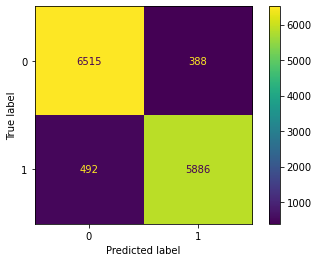

In [ ]:
#Multinomial Naive Bayes Classifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

MNBCmodel = pipe.fit(x_train, y_train)
prediction = MNBCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
Multinomial_Naive_Bayes_accuracy = round(accuracy_score(y_test, prediction)*100,2)

print("f1_score: {}%".format(round(f1_score(y_test, prediction)*100,2)))

cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


accuracy: 93.01%
f1_score: 92.93%


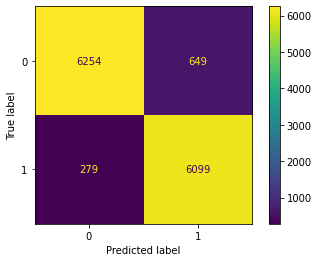

In [ ]:
#Bernoulli Naive Bayes Classifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', BernoulliNB())])

BNBCmodel = pipe.fit(x_train, y_train)
prediction = BNBCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
Bernoulli_Naive_Bayes_accuracy = round(accuracy_score(y_test, prediction)*100,2)

print("f1_score: {}%".format(round(f1_score(y_test, prediction)*100,2)))

cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#NuSVM
from sklearn.svm import NuSVC
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NuSVC())])

NuSVCmodel = pipe.fit(x_train, y_train)
prediction = NuSVCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
NuSVC_accuracy = round(accuracy_score(y_test, prediction)*100,2)
print("f1_score: {}%".format(round(f1_score(y_test, prediction)*100,2)))

accuracy: 96.93%


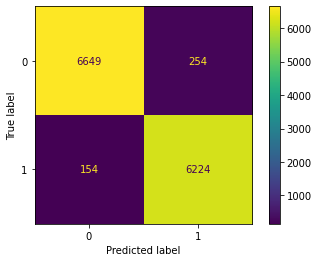

In [ ]:
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
#SVM
from sklearn.svm import SVC
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SVC())])

SVCmodel = pipe.fit(x_train, y_train)
prediction = SVCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
SVC_accuracy = round(accuracy_score(y_test, prediction)*100,2)
print("f1_score: {}%".format(round(f1_score(y_test, prediction)*100,2)))

accuracy: 99.0%
f1_score: 98.97%


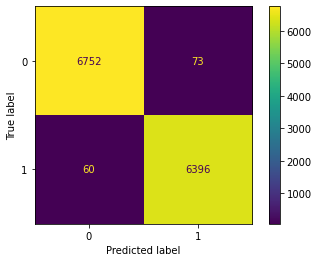

In [ ]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()